In [1]:
import os
import pytest
import numpy as np
import matplotlib.pyplot as plt

from temgymbasic.model import (
    Model,
)

from temgymbasic.utils import calculate_phi_0
import temgymbasic.components as comp
from temgymbasic.utils import zero_phase, zero_phase_1D, FresnelPropagator, lens_phase_factor
from diffractio.scalar_sources_XY import Scalar_source_XY

# Import and configure ipytest
import ipytest
ipytest.autoconfig()

try:
    import cupy as cp
except ImportError:
    cp = None

# Check environment variable to decide backend
USE_GPU = os.getenv('USE_GPU', '0') == '1'

if USE_GPU:
    xp = cp
else:
    xp = np

%matplotlib widget

c:\Users\dl277493\AppData\Local\miniforge3\envs\temgym\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
@pytest.fixture(params=[
    (0, 0, 0.0),
    (3, 0, 0.0),
    (0, -3, 0.0),
    (-3, 3, 0.0),
])
def gaussian_beam_freespace_model(request):
    wavelength = 0.01
    size = 512
    pixel_size = 0.01
    wo = 0.1
    prop_dist = 25

    theta_x, theta_y, x0 = request.param

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=0,
            wo=wo,
            tilt_yx=tilt_yx,
            centre_yx=(0, x0),
        ),
        comp.AccumulatingDetector(
            z=prop_dist,
            pixel_size=pixel_size,
            shape=det_shape,
            buffer_length=64,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, prop_dist


@pytest.fixture(params=[
    (0, 0, 0.1),
    (0, 0, 0.0),
    (5, 0, 0.0),
    (0, -5, 0.0),
    (-5, 5, 0.0),
])
def gaussian_beam_lens_model(request):
    wavelength = 0.01
    size = 512
    pixel_size = 0.002
    wo = 0.04

    theta_x, theta_y, x0 = request.param #(0, 0, x0)

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    lens_dist = 1
    f = 2
    prop_dist = f

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=0,
            wo=wo,
            tilt_yx=tilt_yx,
            centre_yx=(0, x0),
        ),
        comp.Lens(
            z=lens_dist,
            f=f,
        ),
        comp.Detector(
            z=lens_dist + prop_dist,
            pixel_size=pixel_size,
            shape=det_shape,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, prop_dist, lens_dist, f

Freespace

In [3]:
%%ipytest -qq

def test_gaussian_with_free_space(gaussian_beam_freespace_model):
    
    n_rays = 1
    model, wavelength, deg_yx, x0, wo, prop_dist = gaussian_beam_freespace_model

    rays = tuple(model.run_iter(num_rays=n_rays, random=False))
    gbd_output_field = model.detector.get_image(rays)

    size = gbd_output_field.shape[0]

    gbd_output_field = zero_phase(gbd_output_field,
                                    gbd_output_field.shape[0]//2,
                                    gbd_output_field.shape[1]//2)

    # Calculate theta and phi
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    pixel_size = model.components[1].pixel_size

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    shape = model.components[-1].shape
    det_size_y = shape[0] * pixel_size
    det_size_x = shape[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, shape[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, shape[1])

    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
    fresnel_output_field = FresnelPropagator(fresnel_input_field.u,
                                             pixel_size,
                                             wavelength,
                                             prop_dist)

    fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    mask = xp.sqrt((x - center_x)**2 + (y - center_y)**2) <= 25

    # Check if all pixels within the mask satisfy the isclose condition
    is_close = np.isclose(
        np.angle(gbd_output_field),
        np.angle(fresnel_output_field),
        atol=0.1,
    )

    xp.testing.assert_(np.all(is_close[mask]))

    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.imshow(np.abs(gbd_output_field), cmap='gray')
    # ax1.axvline(size // 2, color='white', alpha=0.3)
    # ax1.axhline(size // 2, color='white', alpha=0.3)
    # ax2.imshow(np.angle(gbd_output_field), cmap='RdBu')
    # ax2.axvline(size // 2, color='k', alpha=0.3)
    # ax2.axhline(size // 2, color='k', alpha=0.3)
    # fig.suptitle("GBD")

    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.imshow(np.abs(fresnel_output_field), cmap='gray')
    # ax1.axvline(size // 2, color='white', alpha=0.3)
    # ax1.axhline(size // 2, color='white', alpha=0.3)
    # ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu')
    # ax2.axvline(size // 2, color='k', alpha=0.3)
    # ax2.axhline(size // 2, color='k', alpha=0.3)
    # fig.suptitle("Fresnel")

    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # s = np.s_[size // 2, :]
    # ax1.plot(x_det, np.abs(fresnel_output_field[s]), label="Fresnel")
    # ax1.plot(x_det, np.abs(gbd_output_field[s]), label="GBD")
    # ax1.legend()
    # ax2.plot(x_det, np.angle(fresnel_output_field[s]), label="Fresnel")
    # ax2.plot(x_det, np.angle(gbd_output_field[s]), label="GBD")
    # ax2.legend()

    # fig, ax1 = plt.subplots()
    # ax1.set_title("Phase Difference < 0.1 rad")
    # ax1.imshow(is_close)

# test_gaussian_with_free_space(gaussian_beam_freespace_model)

....                                                                                         [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_with_free_space[gaussian_beam_freespace_model0]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_with_free_space[gaussian_beam_freespace_model1]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_with_free_space[gaussian_beam_freespace_model2]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_with_free_space[gaussian_beam_freespace_model3]
  \\grenfshome01\DL277493\TemGym\src\temgymbasic\utils.py:320: RuntimeWarning: invalid value encountered in sqrt
    radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


Lens

In [4]:
%%ipytest -qq

def test_gaussian_beam_with_lens(gaussian_beam_lens_model):
    # Create a single gaussian ray
    n_rays = 1
    model, wavelength, deg_yx, x0, wo, prop_dist, lens_dist, focal = gaussian_beam_lens_model

    #Propagate it through the model
    rays = tuple(model.run_iter(num_rays=n_rays, random=False))

    #Obtain and zero the phase of the output field
    gbd_output_field = model.detector.get_image(rays)

    size = gbd_output_field.shape[0]

    gbd_output_field = zero_phase(gbd_output_field,
                                gbd_output_field.shape[0]//2,
                                gbd_output_field.shape[1]//2)
    
    #Create coordinates for fresnel propagator model
    pixel_size = model.components[2].pixel_size

    shape = model.components[-1].shape
    det_size_y = shape[0] * pixel_size
    det_size_x = shape[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, shape[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, shape[1])

    # Calculate theta and phi angles for the fresnel propagator
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    # Make similar gaussian beam in fresnel propagator
    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)

    # Run the fresnel propagator
    fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, lens_dist)
    fresnel_output_field = fresnel_output_field * lens_phase_factor(size, pixel_size, wavelength, focal)
    fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, prop_dist)
    fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    mask = xp.sqrt((x - center_x)**2 + (y - center_y)**2) <= 25

    # Check if all pixels within the mask satisfy the isclose condition
    is_close = np.isclose(
        np.angle(gbd_output_field),
        np.angle(fresnel_output_field),
        atol=0.1,
    )

    xp.testing.assert_(np.all(is_close[mask]))

    # Visualise output if needed

    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # s = np.s_[size // 2, :]
    # ax1.plot(x_det, np.abs(fresnel_output_field[s]), label="Fresnel")
    # ax1.plot(x_det, np.abs(gbd_output_field[s]), label="GBD")
    # ax1.legend()
    # ax2.plot(x_det, np.angle(fresnel_output_field[s]), label="Fresnel")
    # ax2.plot(x_det, np.angle(gbd_output_field[s]), label="GBD")
    # ax2.legend()
    
# test_gaussian_beam_with_lens(gaussian_beam_lens_model)

.....                                                                                        [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model0]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model1]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model2]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model3]
tests/gaussian_beam_tests/t_1cf0e23a8fe0469e881bc1282cc951f1.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model4]
  \\grenfshome01\DL277493\TemGym\src\temgymbasic\utils.py:320: RuntimeWarning: invalid value encountered in sqrt
    radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))

-- Docs

Making sure that our Fresnel Propagator is accurate against the analytic methods for gaussian beam propagation.

In [5]:
%%ipytest -qq

def test_fresnel_against_analytical_gaussian_beam_propagation():
    # Rayleigh Range
    def R(z, z_r):
        return z * (1 + (z_r / z) ** 2)

    # Initial complex curvature
    def get_qinv(z_r):
        qinv = 1 / (1j * z_r)
        return qinv

    def get_amplitude(A, B, Qpinv, Amplitude):
        return Amplitude / np.sqrt((A + B * Qpinv))
    
    # Gaussian Beam Parameters
    Initial_Amplitude = 1.0
    wavelength = 0.04
    x0 = 0.0
    wo = 0.4
    z_r = np.pi * wo ** 2 / wavelength

    # Calculate theta and phi
    deg_yx = np.deg2rad((0, 0))
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    # Detector Parameters
    size = (1024, 1024)
    pixel_size = 0.01
    det_size_y = size[0] * pixel_size
    det_size_x = size[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, size[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, size[1])

    # Experiment Parameters and Transfer Matrix
    z1 = -5.0
    z2 = 5.0

    focal = (1 / z2 - 1 / z1) ** -1

    start_to_lens_transfer_matrix = np.array([[1, np.abs(z1)], [0, 1]])
    lens_transfer_matrix = np.array([[1, 0], [-1/focal, 1]])
    lens_to_end_transfer_matrix = np.array([[1, np.abs(z2)], [0, 1]])

    ABCD = lens_to_end_transfer_matrix @ lens_transfer_matrix @ start_to_lens_transfer_matrix
    A, B, C, D = ABCD[0, 0], ABCD[0, 1], ABCD[1, 0], ABCD[1, 1]
    
    # Analytical Gaussian Beam Output
    q_inv = get_qinv(z_r)
    Propagated_Amplitude = get_amplitude(A, B, q_inv, Initial_Amplitude)

    q1 = 1 / q_inv
    q2 = (A * q1 + B) / (C * q1 + D)

    guoy = np.arctan(np.abs(q2) / z_r)

    analytical_output = np.abs(Propagated_Amplitude) ** 2 * np.exp(-1j * (np.pi / (q2 * wavelength)) * (x_det ** 2)) * np.exp(-1j * guoy)
    analytical_output = zero_phase_1D(analytical_output, size[0] // 2)

    # Fresnel Propagation Experimental Parameters
    theta = np.arctan(np.sqrt(tan_theta_x ** 2 + tan_theta_y ** 2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    # Fresnel Propagation with Diffraction and our Fresnel Propagator
    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=Initial_Amplitude, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)

    fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, np.abs(z1))
    fresnel_output_field = fresnel_output_field * lens_phase_factor(size[0], pixel_size, wavelength, focal)
    fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, np.abs(z2))
    fresnel_output_field = zero_phase(fresnel_output_field, size[0] // 2, size[1] // 2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size[0] // 2, size[1] // 2
    y, x = np.ogrid[:size[0], :size[1]]
    mask = xp.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) <= 5

    # Not possible with the lens to test properly - too much deviation outside the centre of the lens
    # Check if all pixels within the mask satisfy the isclose condition
    is_close = np.isclose(
        np.angle(analytical_output),
        np.angle(fresnel_output_field),
        atol=0.4,
    )

    xp.testing.assert_(np.all(is_close[mask]))

    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # s = np.s_[size[0] // 2, :]
    # ax1.plot(np.abs(analytical_output), label="Analytical Output")
    # ax1.plot(np.abs(fresnel_output_field[s]), label="Fresnel Output")
    # ax2.plot(np.angle(analytical_output), label="Analytical Output")
    # ax2.plot(-np.angle(fresnel_output_field[s]), label="Fresnel Output")

    # ax2.plot()
    # ax2.legend()


.                                                                                            [100%]


Defocus

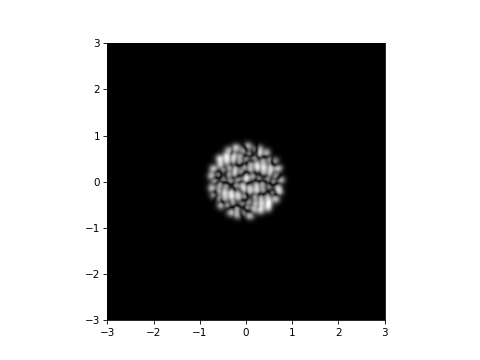

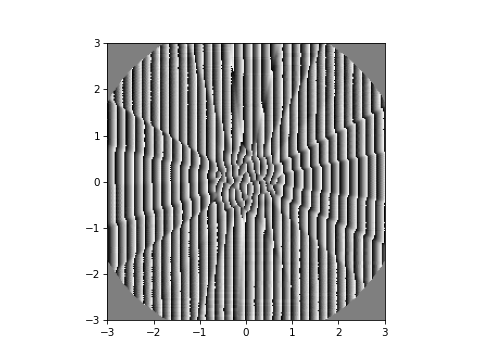

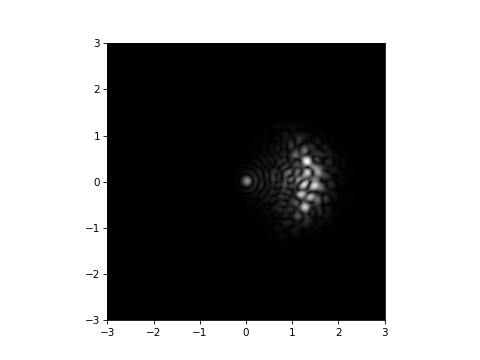

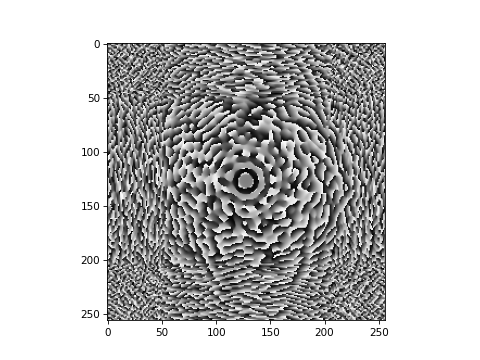

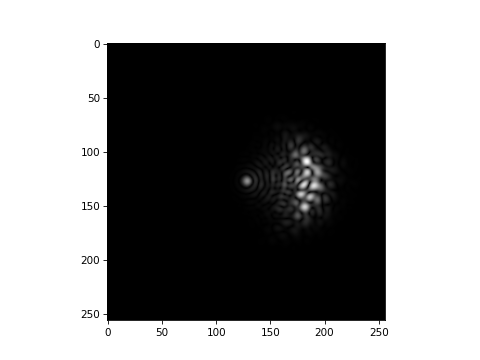

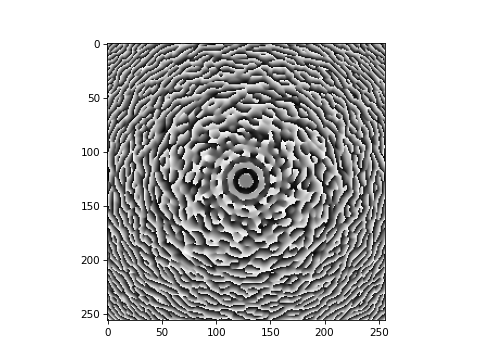

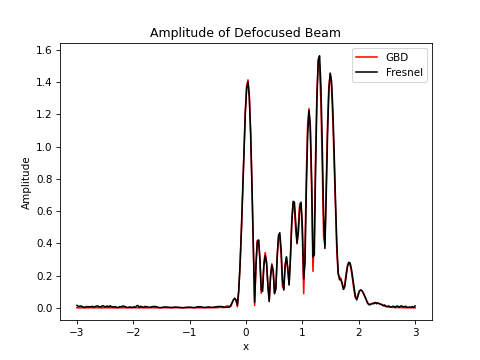

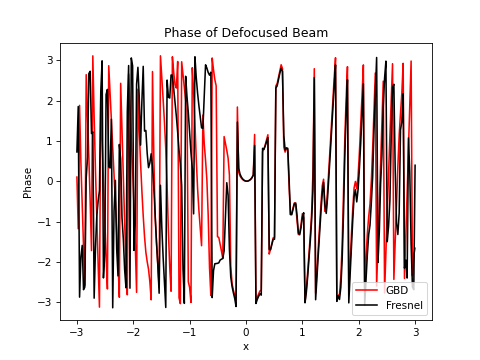

In [15]:
# input parameters

wavelength = 0.0001
size_x = 256

radius = 3
focal = 2000

z_start = 0
z_lens = 1000
z_end = 3000

x0, dx = np.linspace(-radius, radius, size_x, retstep=True)
y0 = x0
Fnum = focal / (2 * radius)
defocus = 1 * wavelength * Fnum ** 2

n_g = 100
wo = 0.1

# W = radius * 2
# OF = (2 * wo * n_g) / W

pixel_size = dx

det_shape = (size_x, size_x)

# Find the input gaussian beam for fresnel propagation - this is messy but right now 
# we just propagate a small distance to a detector to get the input field.
components = (
    comp.GaussBeam(
        z=z_start,
        voltage=calculate_phi_0(wavelength),
        radius=radius/4,
        wo=wo,
        tilt_yx=(0, 0.0005),
    ),
    comp.Detector(
        z=z_start + 1e-10,
        pixel_size=dx,
        shape=det_shape,
    ),
)

model = Model(components, backend='cpu')
rays = tuple(model.run_iter(num_rays=n_g, random=False))

gbd_input_field = model.detector.get_image(rays)

# Take that input field and perform fresnel propagation
u0 = Scalar_source_XY(x0, y0, wavelength)
u0.plane_wave(A=1, theta=0)
u0.u = gbd_input_field

fresnel_output_field = FresnelPropagator(u0.u, pixel_size, wavelength, z_lens)
fresnel_output_field = fresnel_output_field * lens_phase_factor(size_x, pixel_size, wavelength, focal)
fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, focal + defocus)
uend = zero_phase(fresnel_output_field, size_x//2, size_x//2)

# Visualise the output
plt.figure()
plt.imshow(np.abs(u0.u), cmap='gray', extent = [x0.min(), x0.max(), y0.min(), y0.max()])
plt.figure()
plt.imshow(np.angle(u0.u), cmap='gray', extent = [x0.min(), x0.max(), y0.min(), y0.max()])
plt.figure()
plt.imshow(np.abs(uend), cmap='gray', extent = [x0.min(), x0.max(), y0.min(), y0.max()])

plt.figure()
plt.imshow(np.angle(uend), cmap='gray')

# Perform same operation with rays
components = (
    comp.GaussBeam(
        z=z_start,
        voltage=calculate_phi_0(wavelength),
        radius=radius/4,
        tilt_yx=(0, 0.0005),
        wo=wo,
    ),
    comp.Lens(
        z=z_lens,
        f=focal,
    ),
    comp.Detector(
        z=z_end + defocus,
        pixel_size=pixel_size,
        shape=det_shape,
    ),
)


model = Model(components, backend='cpu')
rays = tuple(model.run_iter(num_rays=n_g, random=False))

gbd_output_field = model.detector.get_image(rays)
gbd_output_field = zero_phase(gbd_output_field, size_x//2, size_x//2)

# Plot the output field
plt.figure()
plt.imshow(np.abs(gbd_output_field), cmap='gray')

plt.figure()
plt.imshow(np.angle(gbd_output_field), cmap='gray')

# Plot the cross sections
gbd_end_field = gbd_output_field[size_x//2, :]
fresnel_end_field = uend[size_x//2, :]

gbd_end_field_amp = np.abs(gbd_end_field)
fresnel_end_field_amp = np.abs(fresnel_end_field)
gbd_end_field_phase = np.angle(gbd_end_field)
fresnel_end_field_phase = np.angle(fresnel_end_field)

plt.figure()
plt.plot(x0, gbd_end_field_amp, label="GBD", color = 'red')
plt.plot(x0, fresnel_end_field_amp, label="Fresnel", color = 'k')
plt.title("Amplitude of Defocused Beam")
plt.xlabel("x")
plt.ylabel("Amplitude")

plt.legend()
plt.figure()
plt.plot(x0, gbd_end_field_phase, label="GBD", color = 'red')
plt.plot(x0, fresnel_end_field_phase, label="Fresnel", color = 'k')
plt.title("Phase of Defocused Beam")
plt.xlabel("x")
plt.ylabel("Phase")
plt.legend()

In [16]:
#Test Spherical aberration, distortion and coma

In [17]:
#Test Aperture Diffraction Pattern

In [18]:
#Test Arago Spot

In [19]:
#Test Sample Decomposition

In [20]:
# Test Biprism